In [ ]:
# Download our trained model
!gdown -q 1XggxTZzXNd2JIzOIjCYYc4HVoH3SBQeM

In [ ]:
#train-val-test: 70:15:15
!gdown 1u9XcSIB4-UMmgSGa_or2B3bBbgiNZe5I
!unzip -q data_cifar10_ent_split.zip

Downloading...
From (original): https://drive.google.com/uc?id=1u9XcSIB4-UMmgSGa_or2B3bBbgiNZe5I
From (redirected): https://drive.google.com/uc?id=1u9XcSIB4-UMmgSGa_or2B3bBbgiNZe5I&confirm=t&uuid=956dd28a-9f8a-4e1d-9178-5956efb45a48
To: /content/data_cifar10_ent_split.zip
100% 1.06G/1.06G [00:06<00:00, 154MB/s]


In [ ]:
!pip -q install ftfy regex tqdm
!pip -q install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.2 MB/s eta 0:00:00


In [ ]:
import os
import torch
import clip
from PIL import Image
import torch.nn.functional as F
import random
import numpy as np

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import json
import csv
from pathlib import Path
from tqdm import tqdm
import timm
import pickle
import warnings
import torch.nn.init as init

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model (ViT-B/32)
model, preprocess = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 28.1MiB/s]


In [ ]:
embed_dim = 512
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=10.0):
        super().__init__()
        # Fixed random weights for projecting scalar t to higher frequency space
        self.W = nn.Parameter(torch.randn(1, embed_dim // 2) * scale, requires_grad=False)

    def forward(self, t):
        # Ensure t has shape [B, 1]
        if t.ndim == 1:
            t = t.unsqueeze(-1)
        proj = t * self.W  # Shape: [B, D/2]
        # Return sinusoidal and cosinusoidal projection: [sin(tW), cos(tW)] → Shape: [B, D]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class VectorField(nn.Module):
    def __init__(self, dim, t_dim=32, hidden_dim=256, n_heads=4, dropout_prob=0.1):
        super().__init__()
        self.x_norm = nn.LayerNorm(dim)  # Normalize input embeddings
        self.time_encoder = GaussianFourierProjection(t_dim)  # Time embedding module
        self.dropout = nn.Dropout(dropout_prob)

        # Create multiple independent heads (like a lightweight transformer block)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim + t_dim, hidden_dim),     # Project input + time
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),                               # Activation: SiLU
                nn.Dropout(dropout_prob),
                nn.Linear(hidden_dim, dim)              # Back to original embedding dimension
            ) for _ in range(n_heads)
        ])

        self.res_weight = nn.Parameter(torch.tensor(1.0))  # Learnable residual scaling
        self.out_norm = nn.LayerNorm(dim)  # Final normalization (not applied directly here)
        self.initialize_weights()


    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Use Kaiming initialization (good for ReLU/SiLU)
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)


    def forward(self, x, t):
        # Handle scalar or 1D tensor time input → ensure shape [B, 1]
        if not isinstance(t, torch.Tensor):
            t = torch.full((x.shape[0], 1), t, device=x.device)
        elif t.ndim == 0:
            t = t.expand(x.shape[0], 1)
        elif t.ndim == 1:
            t = t.unsqueeze(-1)

        x_normed = self.x_norm(x)                     # Normalize input
        t_encoded = self.time_encoder(t.to(x.device)) # Encode time t
        inp = torch.cat([x_normed, t_encoded], dim=-1)  # Concatenate along feature dim

        # Pass through each head and average their outputs
        head_outs = [head(inp) for head in self.heads]
        out = torch.mean(torch.stack(head_outs), dim=0)

        # Add residual connection scaled by learnable weight
        return out + self.res_weight * x

In [ ]:
def load_images_recursively(folder):
    '''
    Embed all images in the training data and return them in a dictionary
    Return:
                embeddings = {
                    "img_name": embedding_tensor,
                    ...
                }
    '''
    embeddings = {}
    for root, dirs, files in os.walk(folder):
        for fn in files:
            if fn.lower().endswith((".png", ".jpg", ".jpeg")):
                path = os.path.join(root, fn)
                try:
                    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
                    with torch.no_grad():
                        emb = model.encode_image(image)
                        emb = emb / emb.norm(dim=-1, keepdim=True)
                    rel_path = os.path.relpath(path, img_dir)
                    embeddings[rel_path] = emb.squeeze(0).cpu()
                except Exception as e:
                    print(f"Failed to load {path}: {e}")
    return embeddings

In [ ]:

def create_cls_map(root_dir):
    """
    Create a mapping from relative image path to its class name.

    Args:
        root_dir (str): Root directory containing class-named subfolders with images.

    Returns:
        dict: {
            "class_name/image_name.jpg": "class_name",
            ...
        }
    """
    cls_map = {}
    for cls_name in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls_name)
        if not os.path.isdir(cls_path):
            continue
        for img_name in os.listdir(cls_path):
            if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                rel_path = f"{cls_name}/{img_name}"  # or use os.path.join and os.path.relpath for robustness
                cls_map[rel_path] = cls_name
    return cls_map

In [ ]:
root_dir_test = "./test"
img_dir= root_dir_test
def standardize_keys(d):
    return {
        os.path.join(os.path.basename(os.path.dirname(k)), os.path.basename(k)): v
        for k, v in d.items()
    }

# 1. Load embeddings
embeddings_test = load_images_recursively(root_dir_test)
print(f" Total images loaded: {len(embeddings_test)}")

# 2. Load cls_map
cls_map_test = create_cls_map(root_dir_test)
print(f" Created cls_map for {len(cls_map_test)} images")

# 3.  Standardize keys
embeddings_test = standardize_keys(embeddings_test)
cls_map_test = standardize_keys(cls_map_test)



 Total images loaded: 284
 Created cls_map for 284 images


In [ ]:
# Initialize the learned time-dependent vector field module
vf = VectorField(embed_dim).to(device).float()

# Load the pre-trained weights for the vector field
vf.load_state_dict(torch.load("./vf_model.pth", map_location=device))
vf.eval()  # Set to evaluation mode

VectorField(
  (x_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (time_encoder): GaussianFourierProjection()
  (dropout): Dropout(p=0.1, inplace=False)
  (heads): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=544, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=256, out_features=512, bias=True)
    )
  )
  (out_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
def euler_integration(x0, vf, steps=10):
    """
    Args:
        x0: initial embeddings [B, D]
        vf: vector field model (takes in x and t, returns dx/dt)
        steps: number of integration steps
    Returns:
        Transformed embeddings x(T)
    """
    dt = 1.0 / steps
    x = x0
    for i in range(steps):
        t = i * dt
        k1 = vf(x, t)
        k2 = vf(x + 0.5 * dt * k1, t + 0.5 * dt)
        k3 = vf(x + 0.5 * dt * k2, t + 0.5 * dt)
        k4 = vf(x + dt * k3, t + dt)
        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return x


## Flow matching - Step = 10

In [ ]:
import torch.nn.functional as F
from collections import defaultdict

def compute_recall_at_k_per_class_exact(embeddings, cls_map, vf, device="cuda", ks=[1, 5, 10]):
    """
    embeddings: dict[str] → torch.Tensor (vector chưa qua VF)
    cls_map: dict[str] → class name
    vf: vector field model
    ks: list of k values (e.g., [1, 5, 10])
    """
    keys = list(embeddings.keys())

    embedded_vectors = {}
    for k in keys:
        emb = embeddings[k].unsqueeze(0).to(device).float()
        emb = euler_integration(emb, vf, steps=10)
        t = torch.tensor([[0.0]], device=emb.device, dtype=emb.dtype)
        emb = vf(emb, t)  # Output shape: [1, D]
        embedded_vectors[k] = emb.squeeze(0).cpu()  # [D]

    # Step 2: Tính recall@k theo đúng class
    classwise_results = {cls: {f"Recall@{k}": 0 for k in ks} for cls in set(cls_map.values())}
    classwise_counts = defaultdict(int)
    global_correct = {f"Recall@{k}": 0 for k in ks}
    total = 0

    for anchor_name in keys:
        anchor_emb = embedded_vectors[anchor_name].unsqueeze(0)
        anchor_cls = cls_map[anchor_name]

        # Tính cosine similarity với tất cả vector khác
        sims = []
        for other_name in keys:
            if other_name == anchor_name:
                continue
            other_emb = embedded_vectors[other_name].unsqueeze(0)
            sim = F.cosine_similarity(anchor_emb, other_emb, dim=1).item()
            sims.append((other_name, sim))

        sims = sorted(sims, key=lambda x: x[1], reverse=True)

        for k in ks:
            topk = sims[:k]
            topk_classes = [cls_map[name] for name, _ in topk]

            if anchor_cls in topk_classes:
                classwise_results[anchor_cls][f"Recall@{k}"] += 1
                global_correct[f"Recall@{k}"] += 1

        classwise_counts[anchor_cls] += 1
        total += 1

    # Step 3: Tính Recall@k trung bình cho từng class
    final_classwise = {}
    for cls, recalls in classwise_results.items():
        count = classwise_counts[cls]
        if count == 0:
            continue
        final_classwise[cls] = {k: v / count for k, v in recalls.items()}

    # Step 4: Tính Recall@k tổng thể
    overall = {k: v / total for k, v in global_correct.items()}

    return final_classwise, overall

final_classwise, overall = compute_recall_at_k_per_class_exact(
    embeddings= embeddings_test,   # dict[str] → tensor (chưa qua VF)
    cls_map=cls_map_test,             # dict[str] → class name
    vf=vf,                       # vector field model đã load
    device=device                # thường là 'cuda'
)
# Step 5: Tính trung bình mỗi chỉ số Recall@K trên tất cả các class
recall_avg_per_k = {}
if final_classwise:
    sample_class = next(iter(final_classwise.values()))  # lấy 1 class bất kỳ
    ks = sample_class.keys()
    for k in ks:
        values = [recalls[k] for recalls in final_classwise.values()]
        recall_avg_per_k[k] = sum(values) / len(values)

print("\n📊 Average Recall@K (across classes):")
for k, v in recall_avg_per_k.items():
    print(f"{k}: {v:.4f}")

# In kết quả
for cls, scores in final_classwise.items():
    print(f"🔹 {cls}")
    for k, v in scores.items():
        print(f"  {k}: {v:.4f}")

print("\n📊 Overall:")
for k, v in overall.items():
    print(f"{k}: {v:.4f}")



📊 Average Recall@K (across classes):
Recall@1: 0.6791
Recall@5: 0.8698
Recall@10: 0.9120
🔹 vc-closed
  Recall@1: 0.7188
  Recall@5: 0.8438
  Recall@10: 0.8438
🔹 vc-open
  Recall@1: 0.8919
  Recall@5: 0.9730
  Recall@10: 0.9730
🔹 nose-right
  Recall@1: 0.5652
  Recall@5: 0.8986
  Recall@10: 0.9710
🔹 nose-left
  Recall@1: 0.6901
  Recall@5: 0.9437
  Recall@10: 0.9718
🔹 ear-right
  Recall@1: 0.6333
  Recall@5: 0.8667
  Recall@10: 0.9667
🔹 throat
  Recall@1: 0.6471
  Recall@5: 0.7059
  Recall@10: 0.7647
🔹 ear-left
  Recall@1: 0.6071
  Recall@5: 0.8571
  Recall@10: 0.8929

📊 Overall:
Recall@1: 0.6725
Recall@5: 0.8944
Recall@10: 0.9366


## Flow matching  - Step = 0

In [ ]:
import torch.nn.functional as F
from collections import defaultdict

def compute_recall_at_k_per_class_exact(embeddings, cls_map, vf, device="cuda", ks=[1, 5, 10]):
    """
    embeddings: dict[str] → torch.Tensor (vector chưa qua VF)
    cls_map: dict[str] → class name
    vf: vector field model
    ks: list of k values (e.g., [1, 5, 10])
    """
    keys = list(embeddings.keys())

    # Step 1: Apply VF tại t = 0.0
    embedded_vectors = {}
    for k in keys:
        emb = embeddings[k].unsqueeze(0).to(device).float()
        #emb = euler_integration(emb, vf, steps=10)
        t = torch.tensor([[0.0]], device=emb.device, dtype=emb.dtype)
        emb = vf(emb, t)  # Output shape: [1, D]
        embedded_vectors[k] = emb.squeeze(0).cpu()  # [D]

    # Step 2: Tính recall@k theo đúng class
    classwise_results = {cls: {f"Recall@{k}": 0 for k in ks} for cls in set(cls_map.values())}
    classwise_counts = defaultdict(int)
    global_correct = {f"Recall@{k}": 0 for k in ks}
    total = 0

    for anchor_name in keys:
        anchor_emb = embedded_vectors[anchor_name].unsqueeze(0)
        anchor_cls = cls_map[anchor_name]

        # Tính cosine similarity với tất cả vector khác
        sims = []
        for other_name in keys:
            if other_name == anchor_name:
                continue
            other_emb = embedded_vectors[other_name].unsqueeze(0)
            sim = F.cosine_similarity(anchor_emb, other_emb, dim=1).item()
            sims.append((other_name, sim))

        sims = sorted(sims, key=lambda x: x[1], reverse=True)

        for k in ks:
            topk = sims[:k]
            topk_classes = [cls_map[name] for name, _ in topk]

            if anchor_cls in topk_classes:
                classwise_results[anchor_cls][f"Recall@{k}"] += 1
                global_correct[f"Recall@{k}"] += 1

        classwise_counts[anchor_cls] += 1
        total += 1

    # Step 3: Tính Recall@k trung bình cho từng class
    final_classwise = {}
    for cls, recalls in classwise_results.items():
        count = classwise_counts[cls]
        if count == 0:
            continue
        final_classwise[cls] = {k: v / count for k, v in recalls.items()}

    # Step 4: Tính Recall@k tổng thể
    overall = {k: v / total for k, v in global_correct.items()}

    return final_classwise, overall

final_classwise, overall = compute_recall_at_k_per_class_exact(
    embeddings= embeddings_test,   # dict[str] → tensor (chưa qua VF)
    cls_map=cls_map_test,             # dict[str] → class name
    vf=vf,                       # vector field model đã load
    device=device                # thường là 'cuda'
)
# Step 5: Tính trung bình mỗi chỉ số Recall@K trên tất cả các class
recall_avg_per_k = {}
if final_classwise:
    sample_class = next(iter(final_classwise.values()))  # lấy 1 class bất kỳ
    ks = sample_class.keys()
    for k in ks:
        values = [recalls[k] for recalls in final_classwise.values()]
        recall_avg_per_k[k] = sum(values) / len(values)

print("\n📊 Average Recall@K (across classes):")
for k, v in recall_avg_per_k.items():
    print(f"{k}: {v:.4f}")

# In kết quả
for cls, scores in final_classwise.items():
    print(f"🔹 {cls}")
    for k, v in scores.items():
        print(f"  {k}: {v:.4f}")

print("\n📊 Overall:")
for k, v in overall.items():
    print(f"{k}: {v:.4f}")



📊 Average Recall@K (across classes):
Recall@1: 0.5640
Recall@5: 0.9023
Recall@10: 0.9561
🔹 vc-closed
  Recall@1: 0.5625
  Recall@5: 0.9062
  Recall@10: 0.9375
🔹 vc-open
  Recall@1: 0.7568
  Recall@5: 1.0000
  Recall@10: 1.0000
🔹 nose-right
  Recall@1: 0.3913
  Recall@5: 0.8841
  Recall@10: 0.9420
🔹 nose-left
  Recall@1: 0.4930
  Recall@5: 0.9577
  Recall@10: 1.0000
🔹 ear-right
  Recall@1: 0.6667
  Recall@5: 0.9333
  Recall@10: 0.9667
🔹 throat
  Recall@1: 0.4706
  Recall@5: 0.7059
  Recall@10: 0.8824
🔹 ear-left
  Recall@1: 0.6071
  Recall@5: 0.9286
  Recall@10: 0.9643

📊 Overall:
Recall@1: 0.5387
Recall@5: 0.9190
Recall@10: 0.9648


## Visualize

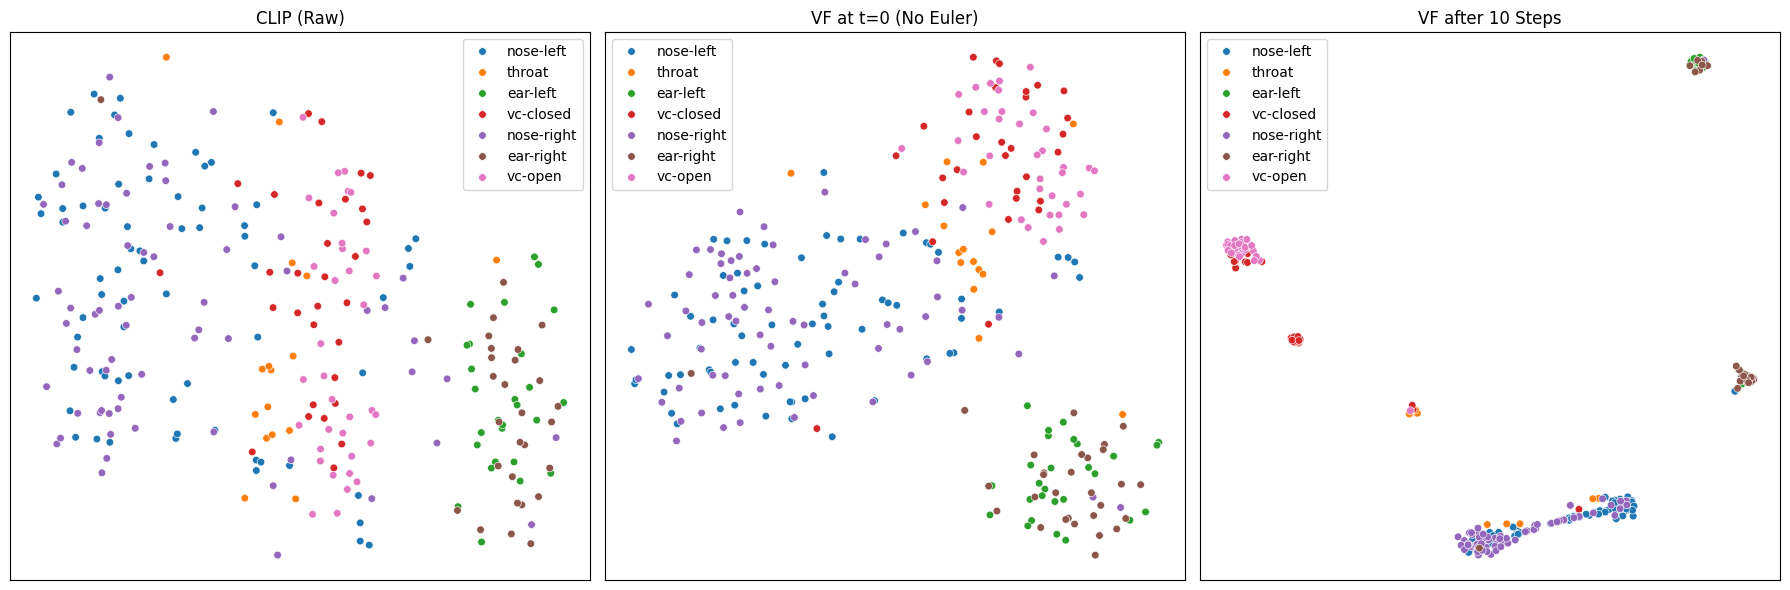

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Bước 1: Tạo 3 phiên bản embedding
embedded_clip = {}     # CLIP thuần (chưa đưa vào VF)
embedded_vf_0 = {}     # Qua VF tại t=0 (không Euler)
embedded_vf_10 = {}    # Qua VF sau Euler 10 steps

for k in embeddings_test.keys():
    emb = embeddings_test[k].unsqueeze(0).to(device).float()

    with torch.no_grad():
        embedded_clip[k] = emb.squeeze(0).cpu()

        # Qua VF tại t=0
        t0 = torch.tensor([[0.0]], device=emb.device, dtype=emb.dtype)
        vf_0 = vf(emb, t0)
        embedded_vf_0[k] = vf_0.squeeze(0).cpu()

        # Qua VF với Euler step=10
        emb_vf = euler_integration(emb, vf, steps=10)
        embedded_vf_10[k] = emb_vf.squeeze(0).cpu()

# Bước 2: Ghép embedding và label
keys = list(embeddings_test.keys())
labels = [cls_map_test[k] for k in keys]

X_clip = torch.stack([embedded_clip[k] for k in keys]).numpy()
X_vf0 = torch.stack([embedded_vf_0[k] for k in keys]).numpy()
X_vf10 = torch.stack([embedded_vf_10[k] for k in keys]).numpy()

# Bước 3: Dùng t-SNE chung để giữ không gian so sánh nhất quán
X_combined = np.concatenate([X_clip, X_vf0, X_vf10], axis=0)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_combined)

# Tách lại
N = len(keys)
X_clip_2d = X_2d[:N]
X_vf0_2d = X_2d[N:2*N]
X_vf10_2d = X_2d[2*N:]

# Bước 4: Vẽ 3 biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=X_clip_2d[:, 0], y=X_clip_2d[:, 1], hue=labels, ax=axes[0], palette='tab10', s=30)
axes[0].set_title("CLIP (Raw)")
axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(x=X_vf0_2d[:, 0], y=X_vf0_2d[:, 1], hue=labels, ax=axes[1], palette='tab10', s=30)
axes[1].set_title("VF at t=0 (No Euler)")
axes[1].set_xticks([]); axes[1].set_yticks([])

sns.scatterplot(x=X_vf10_2d[:, 0], y=X_vf10_2d[:, 1], hue=labels, ax=axes[2], palette='tab10', s=30)
axes[2].set_title("VF after 10 Steps")
axes[2].set_xticks([]); axes[2].set_yticks([])

plt.tight_layout()
plt.show()
